In [229]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [230]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
from collections import OrderedDict
import re
%matplotlib notebook
import json
import sys
# import imp
import random
import copy
import gc
import tables

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(torch.device('cuda:0')))

NVIDIA GeForce RTX 3090


# Load DR4 run 01

The 14th shot is bad

In [4]:
npz_file = np.load('../data_aux/DR4_01_isat.npz')

In [5]:
isat_p22 = npz_file['isat_p22']
isat_p29 = npz_file['isat_p29']
isat_p34 = npz_file['isat_p34']
pos_x_p22 = npz_file['pos_x_p22']
pos_x_p29 = npz_file['pos_x_p29']
pos_x_p34 = npz_file['pos_x_p34']
pos_z = npz_file['pos_z']
timebase = npz_file['timebase']

In [6]:
dt = (timebase[-1] - timebase[0]) / 250000

In [7]:
20e-3/dt

100000.40084284286

In [8]:
30e-3/dt

150000.6012642643

In [9]:
timebase[0]

-0.010000136

<IPython.core.display.Javascript object>


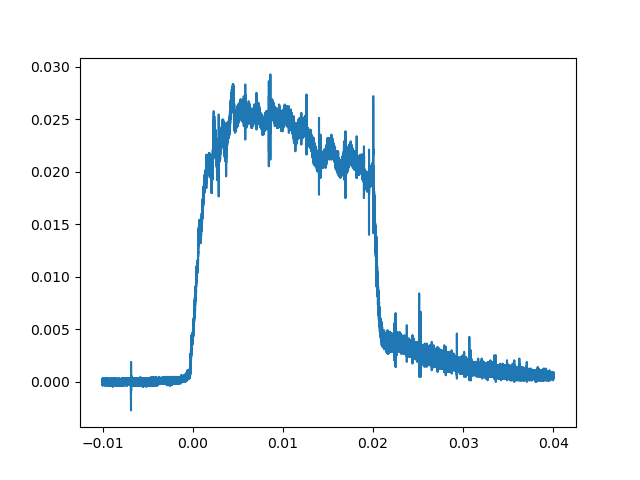

In [231]:
plt.figure()
plt.plot(timebase, isat_p22[10, 0, :])

# Load model

In [11]:
ens_name = 'beta-NLL_wd-0.0'

In [12]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/training_runs/')

In [13]:
runs = sorted(os.listdir(ens_name))
if 'plots' in runs:
    runs.remove('plots')

In [14]:
runs

['2024-09-11_16h-34m-43s',
 '2024-09-11_17h-06m-22s',
 '2024-09-11_17h-37m-46s',
 '2024-09-11_18h-09m-16s',
 '2024-09-11_18h-40m-47s']

In [15]:
model_paths = [ens_name + "/" + run for run in runs]

model_versions = ["checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738",
                  "checkpoints/model-499-738"]

In [16]:
models = []
for model_path, model_version in zip(model_paths, model_versions):
    print("Loading model " + model_path + " version " + model_version)
    os.chdir("/home/phil/Desktop/profile-predict/PP1/training_runs/" + model_path + "/")

    spec = importlib.util.spec_from_file_location("train_dense_beta_NLL_copy", "train_dense_beta_NLL_copy.py")
    loaded_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(loaded_module)
    with open("hyperparams.json") as json_f:
        hyperparams = json.loads(json_f.read())

    # imp.reload(ebm)
    model = loaded_module.ModelClass(hyperparams).to(device)
    # ckpt = torch.load("experiments_modular/" + model_path + "/" + model_version + ".pt")
    ckpt = torch.load(model_version + ".pt")

    model_dict = OrderedDict()
    pattern = re.compile('module.')
    state_dict = ckpt['model_state_dict']
    for k,v in state_dict.items():
        if re.search("module", k):
            model_dict[re.sub(pattern, '', k)] = v
        else:
            model_dict = state_dict
    model.load_state_dict(model_dict, strict=True)

    data_train_path = "/home/phil/Desktop/profile-predict/datasets/" + hyperparams['dataset']

    print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))
    
    models.append(model)
# for model in models:
#     model = model.cpu()

Loading model beta-NLL_wd-0.0/2024-09-11_16h-34m-43s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-06m-22s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_17h-37m-46s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-09m-16s version checkpoints/model-499-738
Number of parameters: 201218
Loading model beta-NLL_wd-0.0/2024-09-11_18h-40m-47s version checkpoints/model-499-738
Number of parameters: 201218


/home/phil/anaconda3/envs/gr-id-pinn-2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
data_train_path = "/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_isat_04_train_cv-0.npz"

In [18]:
train_npz = np.load(data_train_path)
x_mean = train_npz['x_mean']
x_ptp = train_npz['x_ptp']
y_mean = train_npz['y_mean']
y_ptp = train_npz['y_ptp']

In [19]:
RMSE = 0.054 * y_ptp

In [20]:
os.chdir('/home/phil/Desktop/profile-predict/PP1/')
# os.makedirs('plots/' + model_version[12:], exist_ok=True)
# os.makedirs('plots/', exist_ok=True)

# Predict

In [198]:
B_source_arr = np.arange(500, 2001, 250)
B_mirror_arr = np.arange(250, 1501, 250)
B_midplane_arr = np.arange(250, 1501, 250)
GP_voltage_arr = np.arange(70, 91, 5)
discharge_voltage_arr = np.arange(70, 151, 10)
GP_duration = np.linspace(5, 38, 5)
x_arr = np.linspace(0, 20, 21)
y_arr = np.array([0])
# y_arr = np.linspace(0, 20, 21)
z_arr = np.array([859, 1140])
theta_arr = np.array([0])
run_set_flag = np.array([0, 1])
top_GP_flag = np.array([0, 1])

In [199]:
(len(B_source_arr) * 
len(B_mirror_arr) * 
len(B_midplane_arr) * 
len(GP_voltage_arr) * 
len(discharge_voltage_arr) * 
len(GP_duration) * 
len(x_arr) * 
len(y_arr) * 
len(z_arr) * 
len(theta_arr) * 
len(run_set_flag) * 
len(top_GP_flag))

9525600

In [200]:
input_meshgrid = torch.tensor(np.array(np.meshgrid(B_source_arr, 
                             B_mirror_arr, 
                             B_midplane_arr, 
                             GP_voltage_arr, 
                             discharge_voltage_arr,
                             GP_duration, 
                             x_arr, 
                             y_arr, 
                             z_arr, 
                             theta_arr, 
                             run_set_flag, 
                             top_GP_flag,
                            indexing='ij')).reshape(12, -1).transpose(), requires_grad=False, dtype=torch.float32)

input_meshgrid = torch.cat((input_meshgrid,
                           torch.tensor(np.array(np.meshgrid(B_source_arr, 
                             B_mirror_arr, 
                             B_midplane_arr, 
                             GP_voltage_arr, 
                             discharge_voltage_arr, 
                             GP_duration, 
                             y_arr, 
                             x_arr, 
                             z_arr, 
                             theta_arr, 
                             run_set_flag, 
                             top_GP_flag,
                            indexing='ij')).reshape(12, -1).transpose(), requires_grad=False, dtype=torch.float32)), 0)

In [201]:
input_meshgrid = (input_meshgrid - torch.tensor(x_mean, dtype=torch.float32)) / torch.tensor(x_ptp, dtype=torch.float32)

In [202]:
input_meshgrid.shape

torch.Size([19051200, 12])

In [203]:
models_cuda = [m.to('cuda') for m in models]

In [204]:
# del output_meshgrid
gc.collect()
torch.cuda.empty_cache()

In [205]:
def make_predictions():
    outputs = []
    for m in tqdm(models_cuda):
        output_meshgrid = []
        for i in tqdm(range(input_meshgrid.shape[0] // 2500000)):
            temp_outputs = m(input_meshgrid[i*2500000:(i+1)*2500000].to('cuda'))[:, :]
            output_meshgrid.append(temp_outputs.to('cpu').detach().numpy())
            del temp_outputs
            gc.collect()
            torch.cuda.empty_cache()

        output_meshgrid.append(m(input_meshgrid[(i+1)*2500000:].to('cuda'))[:, :].to('cpu').detach().numpy())
        output_meshgrid = np.concatenate(output_meshgrid, axis=0)
        outputs.append(output_meshgrid)
        del output_meshgrid
        gc.collect()
        torch.cuda.empty_cache()
    return outputs

In [206]:
outputs = make_predictions()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [207]:
outputs = np.array(outputs)

In [208]:
outputs.shape

(5, 19051200, 2)

In [209]:
mean_pred = np.mean(outputs[:, :, 0], axis=0)
var_pred = np.mean(outputs[:, :, 1] + outputs[:, :, 0] ** 2, axis=0) - mean_pred ** 2
aleatoric = np.mean(outputs[:, :, 1], axis=0)
epistemic = np.mean(outputs[:, :, 0] ** 2, axis=0) - mean_pred ** 2

In [210]:
isat_mean = mean_pred * y_ptp + y_mean
isat_var = var_pred * y_ptp ** 2
isat_aleatoric = aleatoric * y_ptp ** 2
isat_epistemic = epistemic * y_ptp ** 2

In [211]:
isat_shape_x = (len(B_source_arr), 
              len(B_mirror_arr), 
              len(B_midplane_arr), 
              len(GP_voltage_arr), 
              len(discharge_voltage_arr), 
              len(GP_duration), 
              len(x_arr), 
              len(y_arr), 
              len(z_arr), 
              len(theta_arr), 
              len(run_set_flag), 
              len(top_GP_flag))

isat_shape_y = (len(B_source_arr), 
              len(B_mirror_arr), 
              len(B_midplane_arr), 
              len(GP_voltage_arr), 
              len(discharge_voltage_arr), 
              len(GP_duration), 
              len(y_arr), 
              len(x_arr), 
              len(z_arr), 
              len(theta_arr), 
              len(run_set_flag), 
              len(top_GP_flag))

In [212]:
isat_mean_x = isat_mean[:19051200//2].reshape(*isat_shape_x)
isat_var_x = isat_var[:19051200//2].reshape(*isat_shape_x)
isat_aleatoric_x = isat_aleatoric[:19051200//2].reshape(*isat_shape_x)
isat_epistemic_x = isat_epistemic[:19051200//2].reshape(*isat_shape_x)

In [213]:
isat_mean_y = isat_mean[19051200//2:].reshape(*isat_shape_y)
isat_var_y = isat_var[19051200//2:].reshape(*isat_shape_y)
isat_aleatoric_y = isat_aleatoric[19051200//2:].reshape(*isat_shape_y)
isat_epistemic_y = isat_epistemic[19051200//2:].reshape(*isat_shape_y)

In [214]:
isat_var.shape

(19051200,)

# Compare DR4_01

In [215]:
isat_mean_x.shape

(7, 6, 6, 5, 9, 5, 21, 1, 2, 1, 2, 2)

<IPython.core.display.Javascript object>


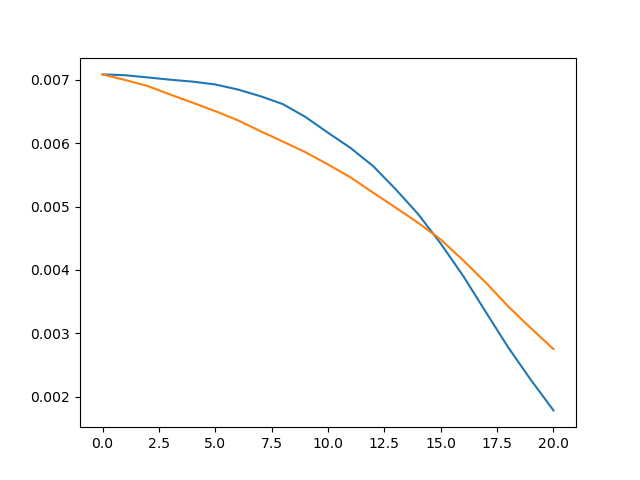

In [216]:
plt.figure()
plt.plot(isat_mean_x[2, 3, 3, 3, 2, 4, :, 0, 0:1, 0, 1, 0])
plt.plot(isat_mean_y[2, 3, 3, 3, 2, 4, 0, :, 0:1, 0, 1, 0])

<IPython.core.display.Javascript object>


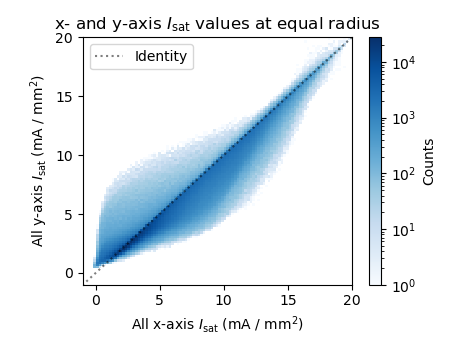

In [228]:
plt.figure(figsize=(4.5, 3.5))
plt.hist2d((isat_mean_x[:, :, :, :,:, :, 0:20, 0, 0:1, 0, 1, :]).reshape(-1) * 1e3,
            (isat_mean_y[:, :, :, :,:, :, 0, 0:20, 0:1, 0, 1, :]).reshape(-1) * 1e3, bins=100, cmap='Blues', norm=matplotlib.colors.LogNorm(), alpha=1)
plt.colorbar(label='Counts')

# plt.hist2d(np.mean(isat_mean_x[:, :, :, :,:, :, 15:20, 0, 0:1, 0, 1, 1], axis=6).reshape(-1),
#             np.mean(isat_mean_y[:, :, :, :,:, :, 0, 15:20, 0:1, 0, 1, 1], axis=6).reshape(-1), bins=100, cmap='Reds', norm=matplotlib.colors.LogNorm(), alpha=0.6)

plt.plot(np.linspace(-2, 25, 2), np.linspace(-2, 25, 2), color='black', linestyle='dotted', alpha=0.5, label='Identity')
plt.xlim(-1, 20)
plt.ylim(-1, 20)
plt.xlabel(r'All x-axis $I_\text{sat}$ (mA / mm$^2$)')
plt.ylabel(r'All y-axis $I_\text{sat}$ (mA / mm$^2$)')
plt.title(r'x- and y-axis $I_\text{sat}$ values at equal radius')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('plots/inference/x-y_asymmetry.pdf')

<IPython.core.display.Javascript object>


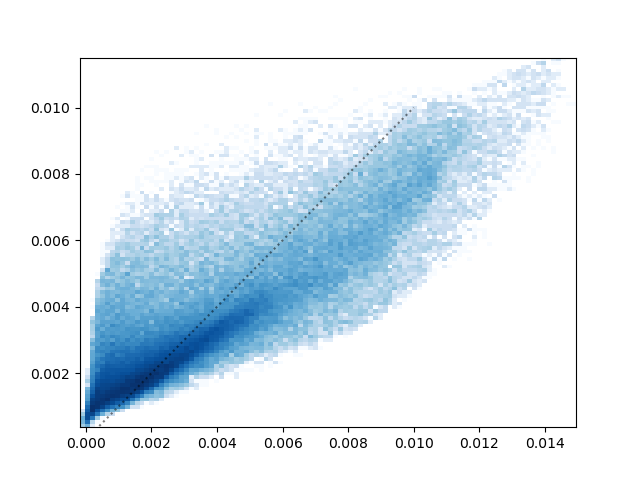

In [226]:
plt.figure()
plt.hist2d((isat_mean_x[:, :, :, :,:, :, 19:20, 0, 0:1, 0, 1, :]).reshape(-1),
            (isat_mean_y[:, :, :, :,:, :, 0, 19:20, 0:1, 0, 1, :]).reshape(-1), bins=100, cmap='Blues', norm=matplotlib.colors.LogNorm(), alpha=1)

# plt.hist2d(np.mean(isat_mean_x[:, :, :, :,:, :, 15:20, 0, 0:1, 0, 1, 1], axis=6).reshape(-1),
#             np.mean(isat_mean_y[:, :, :, :,:, :, 0, 15:20, 0:1, 0, 1, 1], axis=6).reshape(-1), bins=100, cmap='Reds', norm=matplotlib.colors.LogNorm(), alpha=0.6)

plt.plot(np.linspace(-0.002, 0.01, 2), np.linspace(-0.002, 0.01, 2), color='black', linestyle='dotted', alpha=0.5)
# plt.xlim(-0.002, 0.01)
# plt.ylim(-0.002, 0.01)

<IPython.core.display.Javascript object>


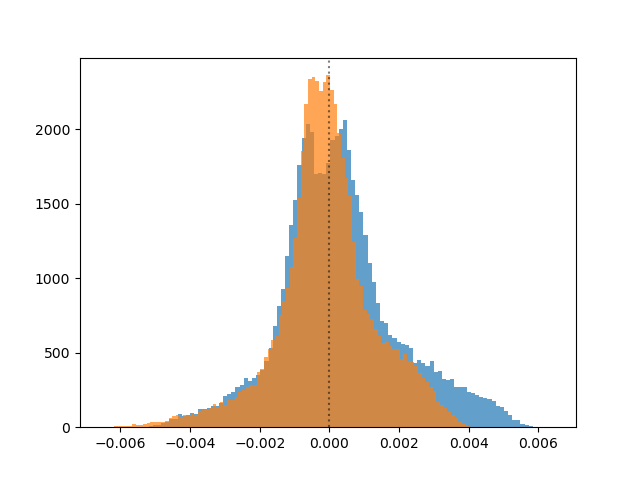

In [227]:
plt.figure()
plt.hist((isat_mean_x[:, :, :, :, :, :, 19:20, 0, 0:1, 0, 1, 0]).reshape(-1) - (isat_mean_y[:, :, :, :, :, :, 0, 19:20, 0:1, 0, 1, 0]).reshape(-1), bins=100, color='tab:blue', alpha=0.7)
plt.hist((isat_mean_x[:, :, :, :, :, :, 19:20, 0, 0:1, 0, 1, 1]).reshape(-1) - (isat_mean_y[:, :, :, :, :, :, 0, 19:20, 0:1, 0, 1, 1]).reshape(-1), bins=100, color='tab:orange', alpha=0.7)
plt.axvline(0, color='black', linestyle='dotted', alpha=0.5)
# plt.yscale('log')

# Look at data

In [232]:
data_all_path = "/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_isat_04.npz"

In [233]:
data_all_npz = np.load(data_all_path)

In [236]:
dr_idx_all = np.load('/home/phil/Desktop/profile-predict/datasets/DR_combo_PP1_dr-idx_04.npz')

In [244]:
dr_planes = []
for dr in list(dr_idx_all.keys()):
    if dr_idx_all[dr].shape[0] > 3000:
        print(dr + ': {}'.format(dr_idx_all[dr].shape))
        dr_planes.append(dr)

DR1_02: (13230,)
DR1_07: (8004,)
DR1_11: (8004,)
DR1_15: (7003,)
DR1_22: (4002,)
DR1_29: (8004,)
DR2_01: (11616,)
DR2_07: (11616,)
DR2_13: (8664,)


In [269]:
data_all_in = data_all_npz['x'] * x_ptp + x_mean

In [290]:
data_all_out = data_all_npz['y'] * y_ptp + y_mean

In [413]:
all_xy_pairs = []
for dr_num in range(len(dr_planes)):
    print(dr_num)
    idx_x_0 = np.where(np.abs(data_all_in[dr_idx_all[dr_planes[dr_num]]][:, 6]) < 1.0)[0]
    idx_y_0 = np.where(np.abs(data_all_in[dr_idx_all[dr_planes[dr_num]]][:, 7]) < 1.0)[0]

    corresponding_y_shot = []
    for i in idx_x_0:
        temp_y_coord = data_all_in[dr_idx_all[dr_planes[dr_num]]][i, 7]
        
        tol = 0.5
#         if dr_num == 0:
#             tol = 0.5
#         elif dr_num == 1:
#             tol = 0.5
#         else:
#             tol = 0.5
        
        temp_shotnums = np.intersect1d(idx_y_0, np.where(np.abs(data_all_in[dr_idx_all[dr_planes[dr_num]]][:, 6] - temp_y_coord) < tol)[0])
        corresponding_y_shot.append((i, temp_shotnums))
        
    xy_pairs = []
    for i, row in enumerate(corresponding_y_shot):
        if len(row[1]) > 0:
            if dr_num == 0:
                xy_pairs.append([row[0], row[1][i % 10]])
            else:
                xy_pairs.append([row[0], row[1][i % 6]])
    xy_pairs = np.array(xy_pairs)
    if len(xy_pairs) > 0:
        all_xy_pairs.append(xy_pairs)

0
1
2
3
4
5
6
7
8


In [414]:
data_isat_vals = []
for dr_num in range(len(all_xy_pairs)):
    data_isat_vals.append(np.array([data_all_out[dr_idx_all[dr_planes[dr_num]]][all_xy_pairs[dr_num][:, 0]],
                                    data_all_out[dr_idx_all[dr_planes[dr_num]]][all_xy_pairs[dr_num][:, 1]]]))

In [415]:
data_isat_concat = np.concatenate(data_isat_vals, axis=1)

<IPython.core.display.Javascript object>


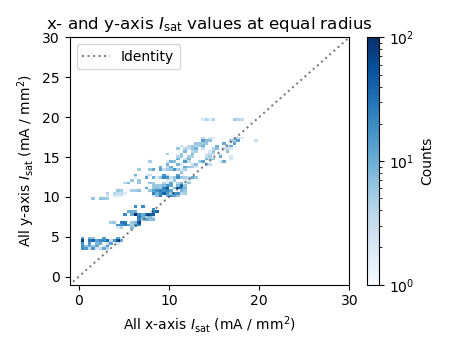

In [416]:
plt.figure(figsize=(4.5, 3.5))
# plt.hist2d(data_all_out[dr_idx_all[dr_planes[0]]][xy_pairs[:, 0]] * 1e3,
#             data_all_out[dr_idx_all[dr_planes[0]]][xy_pairs[:, 1]] * 1e3,
#            bins=10, cmap='Blues', norm=matplotlib.colors.LogNorm(), alpha=1)
plt.hist2d(data_isat_concat[0] * 1e3,
            data_isat_concat[1] * 1e3,
           bins=50, cmap='Blues', norm=matplotlib.colors.LogNorm(), alpha=1)
plt.colorbar(label='Counts')

# plt.hist2d(np.mean(isat_mean_x[:, :, :, :,:, :, 15:20, 0, 0:1, 0, 1, 1], axis=6).reshape(-1),
#             np.mean(isat_mean_y[:, :, :, :,:, :, 0, 15:20, 0:1, 0, 1, 1], axis=6).reshape(-1), bins=100, cmap='Reds', norm=matplotlib.colors.LogNorm(), alpha=0.6)

plt.plot(np.linspace(-2, 50, 2), np.linspace(-2, 50, 2), color='black', linestyle='dotted', alpha=0.5, label='Identity')
plt.xlim(-1, 30)
plt.ylim(-1, 30)
plt.xlabel(r'All x-axis $I_\text{sat}$ (mA / mm$^2$)')
plt.ylabel(r'All y-axis $I_\text{sat}$ (mA / mm$^2$)')
plt.title(r'x- and y-axis $I_\text{sat}$ values at equal radius')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('plots/inference/x-y_asymmetry.pdf')